## Importation des bibliotheques

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import shutil
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.datasets import ImageFolder

from sklearn.metrics import classification_report, confusion_matrix
from timm import create_model
from tqdm import tqdm


## Verification du GPU

In [24]:
print("GPU disponible :", torch.cuda.is_available())
print("Nom du GPU :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Aucun")


GPU disponible : True
Nom du GPU : Tesla T4


## Chargement des donnees

In [25]:
# Chemin du dossier principal
base_path = "/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset"

# Lister les sous-dossiers (classes)
classes = os.listdir(base_path)
print("Classes disponibles :", classes)

Classes disponibles : ['README.md', 'organized_plums_data_new.csv', 'african_plums']


In [26]:
# Chemin vers le dossier african_plums
plums_path = os.path.join(base_path, "african_plums")

# Vérification que le chemin existe
if not os.path.exists(plums_path):
    print("Erreur : Le dossier african_plums n'existe pas à l'emplacement spécifié.")
    print("Contenu du dossier african_plums_dataset :")
    print(os.listdir(base_path))
else:
    print("Dossier african_plums trouvé avec succès !")

Dossier african_plums trouvé avec succès !


In [27]:
if os.path.exists(plums_path):
    # Lister tous les sous-dossiers (classes)
    classes = [d for d in os.listdir(plums_path) 
              if os.path.isdir(os.path.join(plums_path, d))]
    
    print("\nNombre d'images par classe :")
    print("----------------------------")
    
    for class_name in classes:
        class_path = os.path.join(plums_path, class_name)
        num_images = len([f for f in os.listdir(class_path) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        print(f"{class_name}: {num_images} images")


Nombre d'images par classe :
----------------------------
unripe: 826 images
cracked: 162 images
rotten: 720 images
spotted: 759 images
bruised: 319 images
unaffected: 1721 images


In [28]:
plums_path

'/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset/african_plums'

In [29]:
base_dir = plums_path

In [30]:
base_dir

'/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset/african_plums'

## Decoupage des donnees 80/10/10

In [31]:
base_dir = '/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset/african_plums'
output_dir = '/kaggle/working/african_plums_split'

# Créer les dossiers de sortie
for split in ['train', 'val', 'test']:
    for cls in os.listdir(base_dir):
        os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

# Split des images
for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    images = os.listdir(cls_path)
    
    # Split 80% train, 10% val, 10% test
    train_imgs, temp_imgs = train_test_split(images, test_size=0.2, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for img in train_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(output_dir, 'train', cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(output_dir, 'val', cls, img))
    for img in test_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(output_dir, 'test', cls, img))

print("Découpage terminé.")

Découpage terminé.


## Analyse des donnees

Classes: ['bruised', 'cracked', 'rotten', 'spotted', 'unaffected', 'unripe']
Distribution: Counter({4: 1376, 5: 660, 3: 607, 2: 576, 0: 255, 1: 129})


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


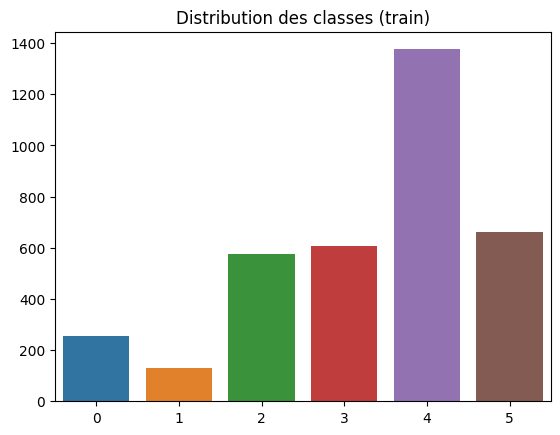

In [32]:
base_dir = '/kaggle/working/african_plums_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_raw = ImageFolder(train_dir)
class_counts = Counter([label for _, label in train_raw.samples])
class_names = train_raw.classes

# Affichage
print("Classes:", class_names)
print("Distribution:", class_counts)
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Distribution des classes (train)")
plt.show()


## Oversampling et Data Augmentation

In [33]:
IMG_SIZE = 224
BATCH_SIZE = 32

# Transformations
base_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

augmented_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3, 0.3, 0.3),
    transforms.RandomRotation(15),
    base_transform
])

# Classe personnalisée
class BalancedAugmentedDataset(ImageFolder):
    def __getitem__(self, index):
        path, label = self.samples[index]
        image = self.loader(path)
        if torch.rand(1) < 0.6:
            return augmented_transform(image), label
        else:
            return base_transform(image), label

train_dataset = BalancedAugmentedDataset(train_dir)
train_dataset.transform = None  # On utilise __getitem__

# Weighted sampler
targets = [label for _, label in train_dataset.samples]
class_sample_counts = np.bincount(targets)
weights = 1. / class_sample_counts[targets]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# Loaders
val_dataset = ImageFolder(val_dir, transform=base_transform)
test_dataset = ImageFolder(test_dir, transform=base_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


## Chargement et résumé du modèle EfficientNetV2

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = create_model("efficientnetv2_s", pretrained=False, num_classes=len(class_names), drop_rate=0.2)
model.to(device)

# Résumé du modèle
print(model)


EfficientNet(
  (conv_stem): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        

## Paramétrage du modèle

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)


##  Boucle d'entraînement avec Early Stopping

In [39]:
EPOCHS = 20
best_val_acc = 0
patience = 3
counter = 0

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break


Epoch 1/20: 100%|██████████| 113/113 [01:17<00:00,  1.46it/s]


Train Loss: 2.7049, Acc: 0.1832 | Val Loss: 2.1507, Acc: 0.2395


Epoch 2/20: 100%|██████████| 113/113 [01:18<00:00,  1.44it/s]


Train Loss: 2.3414, Acc: 0.2304 | Val Loss: 1.5558, Acc: 0.4013


Epoch 3/20: 100%|██████████| 113/113 [01:18<00:00,  1.43it/s]


Train Loss: 2.2406, Acc: 0.2803 | Val Loss: 1.5485, Acc: 0.4213


Epoch 4/20: 100%|██████████| 113/113 [01:17<00:00,  1.46it/s]


Train Loss: 2.1800, Acc: 0.2781 | Val Loss: 1.5688, Acc: 0.3415


Epoch 5/20: 100%|██████████| 113/113 [01:17<00:00,  1.46it/s]


Train Loss: 2.1869, Acc: 0.2920 | Val Loss: 1.5468, Acc: 0.4568


Epoch 6/20: 100%|██████████| 113/113 [01:18<00:00,  1.44it/s]


Train Loss: 2.0760, Acc: 0.2934 | Val Loss: 1.5422, Acc: 0.4102


Epoch 7/20: 100%|██████████| 113/113 [01:19<00:00,  1.42it/s]


Train Loss: 2.0832, Acc: 0.3109 | Val Loss: 1.5685, Acc: 0.4812


Epoch 8/20: 100%|██████████| 113/113 [01:19<00:00,  1.41it/s]


Train Loss: 2.0875, Acc: 0.3178 | Val Loss: 1.8399, Acc: 0.3836


Epoch 9/20: 100%|██████████| 113/113 [01:18<00:00,  1.43it/s]


Train Loss: 2.0706, Acc: 0.3297 | Val Loss: 1.4317, Acc: 0.5455


Epoch 10/20: 100%|██████████| 113/113 [01:20<00:00,  1.40it/s]


Train Loss: 1.9771, Acc: 0.3442 | Val Loss: 1.4334, Acc: 0.4035


Epoch 11/20: 100%|██████████| 113/113 [01:17<00:00,  1.47it/s]


Train Loss: 1.8561, Acc: 0.3672 | Val Loss: 1.3755, Acc: 0.4900


Epoch 12/20:  73%|███████▎  | 82/113 [00:58<00:21,  1.41it/s]


KeyboardInterrupt: 

## Affichage des courbes

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Perte")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Précision")
plt.legend()

plt.show()


## Évaluation finale du modèle

In [ ]:
# Chargement du meilleur modèle
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Rapport
print(classification_report(all_labels, all_preds, target_names=class_names))

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title("Matrice de confusion")
plt.xlabel("Prédits")
plt.ylabel("Réels")
plt.show()


# Amelioration du model

Epoch 1: Train Acc=0.43, Val Acc=0.52
Epoch 2: Train Acc=0.48, Val Acc=0.53
Epoch 3: Train Acc=0.48, Val Acc=0.52
Epoch 4: Train Acc=0.49, Val Acc=0.52
Epoch 5: Train Acc=0.50, Val Acc=0.53
Epoch 6: Train Acc=0.50, Val Acc=0.53
Epoch 7: Train Acc=0.50, Val Acc=0.53
Epoch 8: Train Acc=0.50, Val Acc=0.51
Epoch 9: Train Acc=0.51, Val Acc=0.50
Epoch 10: Train Acc=0.51, Val Acc=0.53


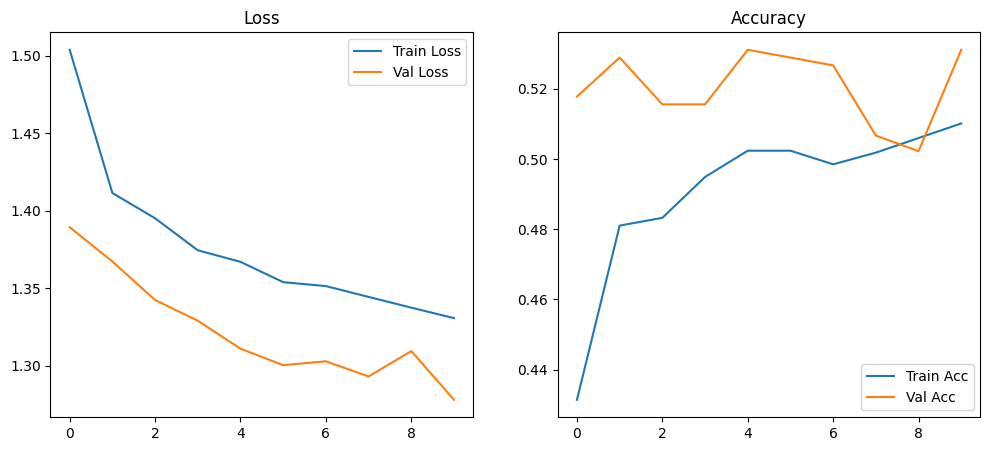

              precision    recall  f1-score   support

     bruised       0.00      0.00      0.00        24
     cracked       0.00      0.00      0.00        18
      rotten       0.52      0.56      0.54        81
     spotted       0.00      0.00      0.00        77
  unaffected       0.49      0.90      0.63       168
      unripe       0.49      0.29      0.37        82

    accuracy                           0.49       450
   macro avg       0.25      0.29      0.26       450
weighted avg       0.36      0.49      0.40       450



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
### 1. Importations
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# CoAtNet simplifié
class CoAtNet(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### 2. Configuration
base_dir = "/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset/african_plums"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 3. Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

### 4. Dataset & Split
dataset = datasets.ImageFolder(base_dir, transform=train_transform)
class_names = dataset.classes

val_size = int(0.1 * len(dataset))
test_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
val_ds.dataset.transform = test_transform
test_ds.dataset.transform = test_transform

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

### 5. Modèle
model = CoAtNet(num_classes=len(class_names))
model.to(device)

### 6. Entraînement
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_acc = 0

for epoch in range(10):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_acc = correct / total

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}, Val Acc={val_acc:.2f}")

### 7. Affichage des courbes
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

### 8. Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))
